# STARCOP dataset exploration demo

In this notebook we will show how to explore the datasets created for the STARCOP project.

Small subsets of this data are available at this
[public Google Drive folder](https://drive.google.com/drive/folders/16FSBkb7cVqYc3f6t3vLQY1s0o0aLLq57). We have uploaded here: the entire test set, subset of the training dataset with large events (called "easy_train") and a mini version of the dataset with only the top 10 largest plumes in train and test (this is just to be used with fast Colab demos).

For the full training dataset please see the details on the Zenodo page - https://doi.org/10.5281/zenodo.7863343.

Here we will show some of the examples of methane events in the dataset.

In [2]:
!pip install --quiet rasterio
!pip install --quiet --upgrade gdown

## Get the data

*Note: the two larger files will take approximately 2-3 minutes to download (as we are downloading almost 14GB to the VM) - so for the demo we will instead use a mini subset (uncomment the other download scripts if you want to download the larger versions)*

In [3]:
# You can download these with gdown:

# STARCOP_mini.zip with 261 MB
!gdown https://drive.google.com/uc?id=1Qw96Drmk2jzBYSED0YPEUyuc2DnBechl -O STARCOP_mini.zip
# STARCOP_test.zip with 5.25 GB
#!gdown https://drive.google.com/uc?id=1TwtSVpbvGd-lWfIjQrw0i4LqkiX2EuHq -O STARCOP_test.zip
# STARCOP_train_easy.zip with 8.38 GB
#!gdown https://drive.google.com/uc?id=1C4ZHvT1ZPKVMFGmqcV12Aozs8Uv_DIxD -O STARCOP_easy_train.zip

public_folder = "." # because we downloaded these locally

Downloading...
From (uriginal): https://drive.google.com/uc?id=1Qw96Drmk2jzBYSED0YPEUyuc2DnBechl
From (redirected): https://drive.google.com/uc?id=1Qw96Drmk2jzBYSED0YPEUyuc2DnBechl&confirm=t&uuid=8e76b713-8402-4a4b-b2cf-ba83506a2ba9
To: /content/STARCOP_mini.zip
100% 274M/274M [00:04<00:00, 60.4MB/s]


## Unzip the data

In [4]:
import os
from glob import glob
files_to_extract = sorted(glob(os.path.join(public_folder,"*.zip")))
print("All:",files_to_extract)

All: ['./STARCOP_mini.zip']


In [5]:
import zipfile
from tqdm import tqdm

dataset_folder = "./datasets"
os.makedirs(dataset_folder, exist_ok=True)

for zip_files in tqdm(files_to_extract):
  with zipfile.ZipFile(zip_files, "r") as zip_ref:
    zip_ref.extractall(dataset_folder)
    zip_ref.close()

100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


In [6]:
# we can delete these now:
!rm *.zip

In [7]:
# Now we have files ready:
folders_in_test = sorted(glob(os.path.join(dataset_folder,"STARCOP_test/*")))
folders_in_test = [f for f in folders_in_test if ".csv" not in f]

print("We have", len(folders_in_test), "folders in the test set.")

folders_in_train_easy = sorted(glob(os.path.join(dataset_folder,"STARCOP_train_easy/*")))
folders_in_train_easy = [f for f in folders_in_train_easy if ".csv" not in f]
print("And we have", len(folders_in_train_easy), "folders in the train_easy subset.")

folders_in_mini = sorted(glob(os.path.join(dataset_folder,"STARCOP_mini/*")))
folders_in_mini = [f for f in folders_in_mini if ".csv" not in f]
print("And we have", len(folders_in_mini), "folders in the mini subset.")

print("\n--\n")

print("Each folder has these files:")
!ls {folders_in_mini[0]}

We have 0 folders in the test set.
And we have 0 folders in the train_easy subset.
And we have 18 folders in the mini subset.

--

Each folder has these files:
labelbinary.tif        TOA_AVIRIS_2310nm.tif  TOA_AVIRIS_640nm.tif  TOA_WV3_SWIR5.tif
label_rgba.tif	       TOA_AVIRIS_2350nm.tif  TOA_WV3_SWIR1.tif     TOA_WV3_SWIR6.tif
mag1c.tif	       TOA_AVIRIS_2360nm.tif  TOA_WV3_SWIR2.tif     TOA_WV3_SWIR7.tif
TOA_AVIRIS_2004nm.tif  TOA_AVIRIS_460nm.tif   TOA_WV3_SWIR3.tif     TOA_WV3_SWIR8.tif
TOA_AVIRIS_2109nm.tif  TOA_AVIRIS_550nm.tif   TOA_WV3_SWIR4.tif     weight_mag1c.tif


In [9]:
print("These are the available csv files:")
!ls datasets/*/*.csv

These are the available csv files:
datasets/STARCOP_mini/test_mini10.csv  datasets/STARCOP_mini/train_mini10.csv


In [10]:
# Choose which one to visualise:
visualise_folder = "datasets/STARCOP_mini" # "datasets/STARCOP_test" # "datasets/STARCOP_train_easy"

csv_file = "datasets/STARCOP_mini/test_mini10.csv"
#csv_file = "datasets/STARCOP_mini/train_mini10.csv"

## Visualise the data

In [11]:
import rasterio.plot as rstplt
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from mpl_toolkits.axes_grid1 import make_axes_locatable

def hide_all_ticks(ax, hide_border=False):
    # hide all ticks
    ax.xaxis.set_tick_params(labelbottom=False)
    ax.yaxis.set_tick_params(labelleft=False)
    ax.set_xticks([])
    ax.set_yticks([])

    #hide border
    if hide_border: ax.axis('off')

def colorbar_next_to(im, ax, size='5%',pad=0.05):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size=size, pad=pad)
    plt.gcf().colorbar(im, cax=cax, orientation='vertical')

def maintain_same_sizes(im, ax, size='5%',pad=0.05):
    # creates and deletes a fake colorbar - to maintain the same plot sizes
    colorbar_next_to(im, ax, size=size, pad=pad)
    fig.delaxes(fig.axes[-1])

In [12]:
import pandas as pd
df = pd.read_csv(csv_file)
df = df.sort_values(by=['qplume'], ascending=False)

In [15]:
# In our work we use this dataframe to hold information about samples in the dataset, see the rows and items in this:
df

,id,candidate_id,qplume,name,folder,date,datetime,window_col_off,window_row_off,window_width,window_height,subset,difficulty,label_path,has_plume,window_labels
0,ang20191018t144405_r2674_c436_w151_h151,ang20191018t144405-3,6957.15116,ang20191018t144405,/AVIRISNG/Permian2019/ang20191018t144405_r2674...,18/10/2019,2019-10-18 14:44:05+00:00,0,0,512,512,test,easy,gs://starcop/Permian/permian_2019_official/ang...,True,"Window(col_off=-180, row_off=-180, width=512, ..."
1,ang20191018t163108_r14851_c525_w151_h151,ang20191018t163108-7,6634.18018,ang20191018t163108,/AVIRISNG/Permian2019/ang20191018t163108_r1485...,18/10/2019,2019-10-18 16:31:08+00:00,0,0,512,512,test,easy,gs://starcop/Permian/permian_2019_official/ang...,True,"Window(col_off=-180, row_off=-180, width=512, ..."
2,ang20191018t141549_r3900_c244_w151_h151,ang20191018t141549-7,5656.60821,ang20191018t141549,/AVIRISNG/Permian2019/ang20191018t141549_r3900...,18/10/2019,2019-10-18 14:15:49+00:00,0,0,512,512,test,easy,gs://starcop/Permian/permian_2019_official/ang...,True,"Window(col_off=-180, row_off=-180, width=512, ..."
3,ang20191025t165545_r6573_c24_w151_h151,ang20191025t165545-4,5637.00737,ang20191025t165545,/AVIRISNG/Permian2019/ang20191025t165545_r6573...,25/10/2019,2019-10-25 16:55:45+00:00,0,0,512,512,test,easy,gs://starcop/Permian/permian_2019_official/ang...,True,"Window(col_off=-180, row_off=-180, width=512, ..."
4,ang20191018t190719_r2696_c420_w151_h151,ang20191018t190719-6,5525.95692,ang20191018t190719,/AVIRISNG/Permian2019/ang20191018t190719_r2696...,18/10/2019,2019-10-18 19:07:19+00:00,0,0,512,512,test,easy,gs://starcop/Permian/permian_2019_official/ang...,True,"Window(col_off=-180, row_off=-180, width=512, ..."
5,ang20191021t191828_r4300_c359_w151_h151,ang20191021t191828-1,5238.20240,ang20191021t191828,/AVIRISNG/Permian2019/ang20191021t191828_r4300...,21/10/2019,2019-10-21 19:18:28+00:00,0,0,512,512,test,easy,gs://starcop/Permian/permian_2019_official/ang...,True,"Window(col_off=-180, row_off=-180, width=512, ..."
6,ang20191018t181457_r4349_c389_w151_h151,ang20191018t181457-7,5128.65293,ang20191018t181457,/AVIRISNG/Permian2019/ang20191018t181457_r4349...,18/10/2019,2019-10-18 18:14:57+00:00,0,0,512,512,test,easy,gs://starcop/Permian/permian_2019_official/ang...,True,"Window(col_off=-180, row_off=-180, width=512, ..."
7,ang20191018t165503_r2660_c460_w151_h151,ang20191018t165503-3,4484.84115,ang20191018t165503,/AVIRISNG/Permian2019/ang20191018t165503_r2660...,18/10/2019,2019-10-18 16:55:03+00:00,0,0,512,512,test,easy,gs://starcop/Permian/permian_2019_official/ang...,True,"Window(col_off=-180, row_off=-180, width=512, ..."
8,ang20191018t190719_r1941_c33_w151_h151,ang20191018t190719-4,3814.11079,ang20191018t190719,/AVIRISNG/Permian2019/ang20191018t190719_r1941...,18/10/2019,2019-10-18 19:07:19+00:00,0,0,512,512,test,easy,gs://starcop/Permian/permian_2019_official/ang...,True,"Window(col_off=-180, row_off=-180, width=512, ..."


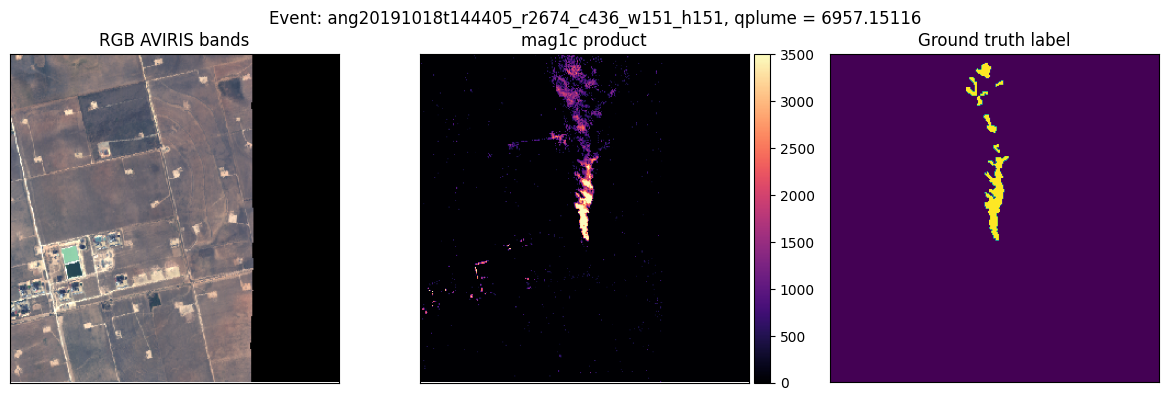

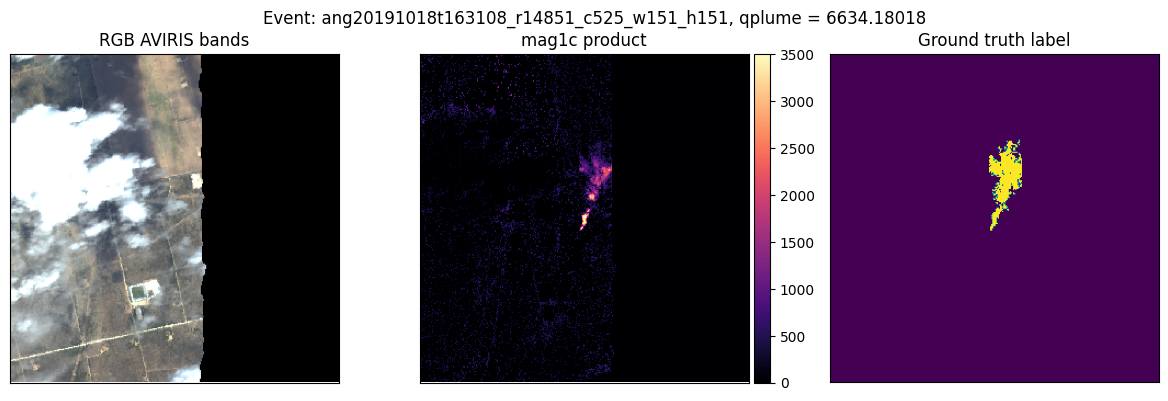

In [16]:
size_read = 300
show_first = 2
fig_size_multiplier = 4

for idx, event_id in enumerate(list(df["id"])):
  ft = os.path.join(visualise_folder, event_id)
  # Typical input for our hyperspectral model: RGB + mag1c
  aviris_r = os.path.join(ft, "TOA_AVIRIS_640nm.tif")
  aviris_g = os.path.join(ft, "TOA_AVIRIS_550nm.tif")
  aviris_b = os.path.join(ft, "TOA_AVIRIS_460nm.tif")
  magic_path = os.path.join(ft, "mag1c.tif")
  # Ground truth:
  gt_path = os.path.join(ft, "labelbinary.tif")
  n_plots = 3

  with rasterio.open(gt_path) as src:
    width = src.width
    height = src.height

    # Compute shape to read to from pyramids and speed up plotting
    shape = src.shape
    if (size_read >= shape[0]) and (size_read >= shape[1]):
      out_shape = shape
    elif shape[0] > shape[1]:
      out_shape = (size_read, int(round(shape[1]/shape[0] * size_read)))
    else:
      out_shape = (int(round(shape[0] / shape[1] * size_read)), size_read)
    gt = src.read(1, out_shape=out_shape)

  with rasterio.open(magic_path) as src:
    magic = src.read(1, out_shape=out_shape)
  with rasterio.open(aviris_r) as src:
    r = src.read(1, out_shape=out_shape)
  with rasterio.open(aviris_g) as src:
    g = src.read(1, out_shape=out_shape)
  with rasterio.open(aviris_b) as src:
    b = src.read(1, out_shape=out_shape)

  rgb = np.asarray([r,g,b])

  fig, axes = plt.subplots(1, n_plots, figsize=(n_plots*fig_size_multiplier*width/height,fig_size_multiplier), tight_layout=True)

  # Plot GT
  ax = axes[-1]
  im=ax.imshow(gt)
  ax.set_title(f"Ground truth label")
  hide_all_ticks(ax)
  maintain_same_sizes(im,ax)

  # Plot RGB
  ax = axes[0]
  rgb = np.clip(rgb/60., 0, 2)
  im = ax.imshow(np.transpose(np.asanyarray(rgb),(1,2,0)))
  ax.set_title(f"RGB AVIRIS bands")
  hide_all_ticks(ax)
  maintain_same_sizes(im,ax)

  # mag1c
  ax = axes[1]
  im=ax.imshow(1750 * np.clip(magic / 1750.0, 0,2))
  im.set_cmap('magma')
  ax.set_title(f"mag1c product")
  hide_all_ticks(ax)
  colorbar_next_to(im, ax)

  name = ft.split("/")[-1]
  qplume = df["qplume"][idx]

  plt.suptitle(f"Event: {name}, qplume = {qplume}")
  plt.show()
  # note: below left with the first two outputs as a demo

  show_first -= 1
  if show_first <= 0: break

## (bonus) Plot location of the data

In the following cell we will show the location of these events around the Permian Basin area using the `folium` package.

*Note: This visualisation shows just the loaded subset of data (in this notebook that is either the mini dataset with 10 samples, or the test dataset, or a train_easy subset).*

In [ ]:
import folium
import rasterio.warp

map_bb = folium.Map(location=[31.70239727088906, -103.58010434928194],
                    zoom_start=8,
                    prefer_canvas=True) #tiles="Stamen Toner")

map_icons = []

for event_id in list(df["id"]):
  ft = os.path.join(visualise_folder, event_id)
  gt_path = os.path.join(ft, "labelbinary.tif")
  with rasterio.open(gt_path) as src:
    bounds_utm = src.bounds
    bounds_lng_lat = rasterio.warp.transform_bounds(src.crs, {"init": "epsg:4326"}, *bounds_utm)
    lng_lat_center = src.lnglat()
    lat_lng_center = lng_lat_center[-1::-1]
    bounds_lng_lat = lng_lat_center[0] - 1, lng_lat_center[1] - 1, lng_lat_center[0] + 1, lng_lat_center[1] + 1

  marker = folium.Circle(location=list(lat_lng_center), radius=1, color='blue', fill_color='blue')
  map_bb.add_child(marker)

# note: this will make more sense for the full dataset, mini version contains only few samples
map_bb